In [36]:
import datetime
from functools import partial
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from typing import List, Callable
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from itertools import product
from collections import Counter
import vectorbt as vbt
from scipy.optimize import minimize
from pandas.tseries.offsets import DateOffset
import numpy as np

In [2]:
class Labeler:
    def __init__(self, name):
        """
        Initialize the labeler.

        Args:
        name (str): The name of the labeler.
        """
        self.name = name

    def fit(self, data):
        """
        Fit the labeler to the data.

        This method should be overridden by subclasses to implement
        the actual fitting logic.

        Args:
        data (any): The data to fit the labeler to.
        """
        raise NotImplementedError("Subclasses must implement this method.")

    def transform(self, data):
        """
        Transform the data into labels.

        This method should be overridden by subclasses to implement
        the actual transformation logic.

        Args:
        data (any): The data to transform into labels.

        Returns:
        any: The labels.
        """
        raise NotImplementedError("Subclasses must implement this method.")

class TripleBarrierLabeler(Labeler):
    def __init__(self, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7, min_trend_days=2, barrier_type='volatility', touch_type="HL", up_label=2, neutral_label=1, down_label=0):
        """
        Initialize the labeler.
        """
        super().__init__(name="triple barrier labeling")
        self.volatility_period = volatility_period
        self.upper_barrier_factor = upper_barrier_factor
        self.lower_barrier_factor = lower_barrier_factor
        self.vertical_barrier = vertical_barrier
        self.min_trend_days = min_trend_days
        self.barrier_type = barrier_type
        self.touch_type = touch_type
        self.up_label = up_label
        self.down_label = down_label
        self.neutral_label = neutral_label

    def calculate_barriers(self, df, i, window):
        """calculate the barriers based on either volatility or returns of the backward window

        Args:
            df (pd.DataFrame): Data
            i (pd.index): the index of the beginning of the window
            window (int): window size

        Returns:
            df: Data including barriers for the forward window
        """
        end_window = min(i+window, len(df)-1)  # Ensure the window does not exceed the dataframe

        # Calculate the mean volatility or daily returns over the volatility_period
        if self.barrier_type == 'volatility':
            current_value = df.loc[i, 'volatility']
        elif self.barrier_type == 'returns':
            current_value = df.loc[i, 'daily_returns']
        else:
            raise ValueError("Invalid barrier_type. Choose either 'volatility' or 'returns'")

        df.loc[i:end_window, 'upper_barrier'] = df.loc[i, 'close'] + (df.loc[i, 'close'] * current_value * self.upper_barrier_factor)
        df.loc[i:end_window, 'lower_barrier'] = df.loc[i, 'close'] - (df.loc[i, 'close'] * current_value * self.lower_barrier_factor)
        return df

    def label_observations(self, df, origin, i, label):
        df.loc[origin:i+1, 'label'] = label
        return df

    def get_daily_vol(self, close, span=30):
        """
        Calculate the EWMA volatility of closing prices.
        
        Parameters:
        - close: A pandas Series of closing prices.
        - span: The span for the EWMA standard deviation.
        
        Returns:
        - A pandas Series of EWMA volatility estimates.
        """
        # Calculate log returns
        log_returns = np.log(close / close.shift(1))
        
        # Calculate EWMA volatility
        ewma_volatility = log_returns.ewm(span=span).std()
        
        return log_returns, ewma_volatility

    def fit(self, sdf):
        df = sdf.copy()
        # Calculate daily returns and volatility
        df['daily_returns'], df['volatility'] = self.get_daily_vol(df.close, self.volatility_period)

        df = df.reset_index()
        # Initialize label and window start
        df['label'] = self.neutral_label
        df['window_start'] = False

        self.data = df

    def transform(self):
        """
        Transform the data into labels.

        Returns:
        pd.DataFrame: The labels.
        """
        window = self.vertical_barrier
        origin = 0
        touch_upper = lambda high, barrier: high >= barrier
        touch_lower = lambda low, barrier: low <= barrier
        # For each observation
        for i in range(0, len(self.data)):
            # Define your barriers at the beginning of each window
            if i == origin:
                self.data = self.calculate_barriers(self.data, i, window)
                self.data.loc[i, 'window_start'] = True  # Mark the start of the window

            # one of the conditions were met
            if touch_upper(self.data.loc[i, "high" if self.touch_type == 'HL' else 'close'], self.data.loc[i, "upper_barrier"]):
                if (i - origin > self.min_trend_days):
                    # label the observations
                    self.data = self.label_observations(self.data, origin, i, self.up_label)
                    # set new origin
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index
                    # reset window
                    window = self.vertical_barrier
            elif touch_lower(self.data.loc[i, "low" if self.touch_type == 'HL' else 'close'], self.data.loc[i, "lower_barrier"]):
                if (i - origin > self.min_trend_days):
                    # label the observations
                    self.data = self.label_observations(self.data, origin, i, self.down_label)
                    # set new origin
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index
                    # reset window
                    window = self.vertical_barrier

            # none of the conditions were met
            else:
                if window > 0:
                    # reduce window size by one
                    window = window - 1
                else:
                    # reset window
                    window = self.vertical_barrier
                    # label neutral from origin to origin + window
                    self.data.loc[origin:min(origin+window, len(self.data)-1), 'label'] = self.neutral_label  # Ensure the window does not exceed the dataframe
                    # set origin to the next id
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index

        self.data = self.data.set_index("timestamp")
        return self.data

def optimize_parameters(price_df, param_grid, initial_capital=100000, num_starts=10, optimization_interval='6M'):
    if optimization_interval is None:
        # Use the whole dataset for optimization
        best_params, best_sharpe_ratio = tune_hyperparameters_scipy(price_df, param_grid, initial_capital, num_starts)
        return pd.DataFrame([{
            'start': price_df.index[0],
            'end': price_df.index[-1],
            'params': best_params,
            'sharpe_ratio': best_sharpe_ratio,
        }])
    else:
        # Optimize parameters at specified intervals
        intervals = pd.date_range(start=price_df.index[0], end=price_df.index[-1], freq=optimization_interval)
        optimized_params = []

        for start, end in zip(intervals[:-1], intervals[1:]):
            interval_df = price_df.loc[start:end]
            best_params, best_sharpe_ratio = tune_hyperparameters_scipy(interval_df, param_grid, initial_capital, num_starts)
            optimized_params.append({
                'start': start,
                'end': end,
                'params': best_params,
                'sharpe_ratio': best_sharpe_ratio,
            })

        return pd.DataFrame(optimized_params)

def tune_hyperparameters_scipy(price_df, param_grid, initial_capital=100000, num_starts=10):
    best_sharpe_ratio, best_net_profit, best_params = -np.inf, -np.inf, None

    param_space = [
        param_grid['volatility_period'],
        param_grid['upper_barrier_factor'],
        param_grid['lower_barrier_factor'],
        param_grid['vertical_barrier'],
        param_grid['barrier_type'],
        param_grid['touch_type']
    ]

    bounds = [(0, len(space) - 1) for space in param_space]

    def bounds_to_params(x):
        return {key: space[int(idx)] for key, space, idx in zip(param_grid.keys(), param_space, x)}

    def objective_wrapper(x):
        params = bounds_to_params(x)
        return sharpe_ratio_objective(params, price_df, initial_capital)

    for _ in tqdm(range(num_starts), desc="Optimizing"):
        initial_guess = [np.random.randint(len(space)) for space in param_space]
        result = minimize(objective_wrapper, initial_guess, method='SLSQP', bounds=bounds)

        if result.success and -result.fun > best_sharpe_ratio:
            best_sharpe_ratio = -result.fun
            best_params = bounds_to_params(result.x)

    return best_params, best_sharpe_ratio

def sharpe_ratio_objective(params, price_df, initial_capital):
    labeler = TripleBarrierLabeler(**params)
    labeler.fit(price_df)
    labeled_df = labeler.transform()
    labeled_df.set_index(price_df.index, inplace=True)
    sharpe_ratio = strategize_and_measure(labeled_df, init_capital=initial_capital)
    return -sharpe_ratio  # Minimize negative Sharpe Ratio to maximize Sharpe Ratio

def strategize_and_measure(price_df, init_capital=1000, fee=0.006):
    entries = price_df["label"] > 1
    short_entries = price_df["label"] < 1
    # Calculate the percentage changes for TP and SL
    price_df['tp_stop'] = (price_df['upper_barrier'] - price_df['close']) / price_df['close']
    price_df['sl_stop'] = (price_df['close'] - price_df['lower_barrier']) / price_df['close']
    # Replace negative values with 0
    price_df['tp_stop'] = price_df['tp_stop'].apply(lambda x: max(x, 0))
    price_df['sl_stop'] = price_df['sl_stop'].apply(lambda x: max(x, 0))

    # Run the backtest
    pf = vbt.Portfolio.from_signals(
        close=price_df['close'],
        entries=entries,
        short_entries=short_entries,
        # size=size,
        tp_stop=price_df['tp_stop'],
        sl_stop=price_df['sl_stop'],
        init_cash=1000,  # Initial cash value
        fees=fee,  # Commission fees (0.5%)
        freq="D"
    )

    return pf.sharpe_ratio()

def compute_metrics_classification(labels, preds, probs, metrics_to_return=None, average="macro", multi_class="ovr"):
    """
    Compute classification metrics based on the model's predictions and the true labels.

    Args:
    labels (any): The true labels.
    preds (any): The model's predictions.
    probs (any): The model's probabilities
    metrics_to_return (list): List of metric names to compute and return.

    Returns:
    dict: The computed classification metrics.
    """
    if metrics_to_return is None:
        metrics_to_return = ["accuracy", "f1", "precision", "recall", "roc_score", "confusion_matrix"]

    metrics = {}

    if "precision" in metrics_to_return or "recall" in metrics_to_return or "f1" in metrics_to_return:
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=average)
        if "precision" in metrics_to_return:
            metrics["precision"] = precision
        if "recall" in metrics_to_return:
            metrics["recall"] = recall
        if "f1" in metrics_to_return:
            metrics["f1"] = f1

    if "accuracy" in metrics_to_return:
        metrics["accuracy"] = accuracy_score(labels, preds)

    if "roc_score" in metrics_to_return:
        metrics["roc_score"] = roc_auc_score(labels, probs, multi_class=multi_class)

    if "confusion_matrix" in metrics_to_return:
        metrics["confusion_matrix"] = confusion_matrix(labels, preds)

    return metrics


def pandas_data_loader(addr: str, columns: List[str], *transforms: Callable[[pd.DataFrame], pd.DataFrame]) -> pd.DataFrame:
    # Load the data from the CSV file
    df = pd.read_csv(addr, usecols=columns)

    # Apply each transform to the DataFrame
    for transform in transforms:
        df = transform(df)

    return df

# Transform index to datetime
def index_to_datetime(df, unit="s"):
    df.index = pd.to_datetime(df.index, unit=unit)
    return df
# Transform col to index
to_index = lambda col, df: df.set_index(col)
# Rename text_plit to text
rename = lambda original, new, df: df.rename(columns={original: new})

In [37]:
# @title load price data
address = "../raw/bitcoin_2015-01-01_2022-01-01.csv" # @param {"type":"string","placeholder":"./raw/daily-2020.csv"}
# Loading the price data
columns = ["timestamp", "close", "open", "high", "low", "volume"]
price_df = pandas_data_loader(address, columns, partial(to_index, "timestamp"), partial(index_to_datetime, unit=None))
price_df = price_df.sort_index()
price_df = price_df[:"2021-02-01"]

In [38]:
# @title load price data
address = "../raw/86400.csv" # @param {"type":"string","placeholder":"./raw/daily-2020.csv"}
# Loading the price data
columns = ["timestamp", "close", "open", "high", "low", "volume"]
new_price_df = pandas_data_loader(address, columns, partial(to_index, "timestamp"), partial(index_to_datetime, unit='s'))
new_price_df = new_price_df.sort_index()
price_df = price_df[:"2021-02-01"]

In [5]:
price_df = pd.concat([price_df, new_price_df["2022-01-02":]])

In [6]:
# @title load text data
address = "../raw/impact_labeled.csv" # @param {"type":"string","placeholder":"./raw/labeled_tweets.csv"}
columns = ["text", "impact_label", "date"]
impact_df = pandas_data_loader(address, columns, partial(to_index, "date"), partial(index_to_datetime, unit='ns'), partial(rename, "text_split", "text"), partial(rename, "impact_label", "impact"))
impact_df = impact_df[:"2021-01-01"]

In [7]:
# @title load text data
address = "../raw/new_tweets.csv" # @param {"type":"string","placeholder":"./raw/labeled_tweets.csv"}
columns = ["text", "predictions", "day"]
new_impact_df = pandas_data_loader(address, columns, partial(to_index, "day"), partial(index_to_datetime, unit='ns'), partial(rename, "predictions", "impact"), partial(rename, "text_split", "text"))
new_impact_df = new_impact_df[:"2021-01-01"]

In [8]:
impact_df = pd.concat([impact_df, new_impact_df])

In [9]:
# @title load text data
address = "../raw/LSTM_preds.csv" # @param {"type":"string","placeholder":"./raw/labeled_tweets.csv"}
columns = ["timestamp", "y_true", "y_pred"]
lstm_df = pandas_data_loader(address, columns, partial(to_index, "timestamp"), partial(index_to_datetime, unit='ns'), partial(rename, "y_pred", "prediction"), partial(rename, "y_true", "label"))
lstm_df = lstm_df[:"2021-01-01"]

In [10]:
# Define the parameter grid
param_grid = {
    # 'volatility_period': [8, 9, 10, 11, 12, 13, 14, 15],
    'upper_barrier_factor': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
    'lower_barrier_factor': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
    'vertical_barrier': [8, 9, 10, 11, 12, 13, 14, 15],
    # 'barrier_type': ['volatility'],
    # 'touch_type': ['HL']
}

In [ ]:
# Optimize parameters every six months
optimized_params_df = optimize_parameters(price_df, param_grid, initial_capital=100000, num_starts=500, optimization_interval='6M')

# Apply the optimized parameters to label the data
labeled_df = pd.DataFrame()
for _, row in optimized_params_df.iterrows():
    start, end, params = row['start'], row['end'], row['params']
    interval_df = price_df.loc[start:end]
    labeler = TripleBarrierLabeler(**params)
    labeler.fit(interval_df)
    labeled_interval_df = labeler.transform()
    labeled_df = pd.concat([labeled_df, labeled_interval_df])

# Check the label distribution
print(labeled_df.label.value_counts(), optimized_params_df.sharpe_ratio)

In [17]:
# labeled_df.to_csv("../raw/optimized_labeled.csv")

In [39]:
# @title load price data
address = "../raw/optimized_labeled.csv" # @param {"type":"string","placeholder":"./raw/daily-2020.csv"}
# Loading the price data
columns = ["timestamp", "close", "open", "high", "low", "volume", "label"]
labeled_df = pandas_data_loader(address, columns, partial(to_index, "timestamp"), partial(index_to_datetime, unit=None))
labeled_df = labeled_df.sort_index()
price_df = price_df[:"2021-02-01"]

In [40]:
def generate_signal_and_size(row, bearish_threshold=1, bullish_threshold=1.1):
    if row < bearish_threshold:
        return 0, abs(row - bearish_threshold)  # Bearish signal and position size
    elif row > bullish_threshold:
        return 2, abs(row - bullish_threshold)  # Bullish signal and position size
    else:
        return 1, 0  # Neutral signal and position size

In [41]:
# Assuming impact_df is your DataFrame
impact_mean = impact_df["impact"].groupby(impact_df.index).mean()
impact_mean = pd.DataFrame(impact_mean)
impact_mean["prediction"], impact_mean["position_size"] = zip(*impact_mean["impact"].apply(generate_signal_and_size))
    
# Rename columns to match the desired output
impact_mean = impact_mean.rename(columns={"impact": "mean_impact"})
impact_mean = impact_mean[["prediction", "position_size"]]

In [42]:
def calculate_majority_confidence(labels):
    count = Counter(labels)
    majority_label, majority_count = count.most_common(1)[0]
    total_count = sum(count.values())
    confidence = majority_count / total_count
    return majority_label, confidence

In [43]:
# Group by date and apply the function to get majority label and confidence
majority_data = impact_df.groupby(impact_df.index)["impact"].apply(calculate_majority_confidence)
majority_df = pd.DataFrame(majority_data.tolist(), index=majority_data.index, columns=["signal", "confidence"])

mapping = {1: 0, 0: -1, 2: 1}
majority_df['signal'] = majority_df['signal'].map(mapping)

# Calculate position size based on confidence
majority_df["position_size"] = majority_df["confidence"]

# Rename columns to match the desired output
impact_majority = majority_df[["signal", "position_size"]]

In [44]:
mapping = {0: 1, -1: 0, 1: 2}
majority_df["prediction"] = majority_df.signal.map(mapping)

In [45]:
labels = labeled_df[["label"]]

In [46]:
majority_labeled = labels.merge(majority_df, left_index=True, right_index=True, how="left")
majority_labeled.dropna(inplace=True)

In [47]:
mean_labeled = labels.merge(impact_mean, left_index=True, right_index=True, how="left")
mean_labeled.dropna(inplace=True)

In [48]:
lstm_labeled = labels.merge(lstm_df, left_index=True, right_index=True, how="left")
lstm_labeled.dropna(inplace=True)

In [49]:
metrics = ["accuracy", "precision", "recall", "f1"]
compute_metrics_classification(majority_labeled["label"], majority_labeled["prediction"], [], metrics_to_return=metrics)

{'precision': 0.6087946578462774,
 'recall': 0.5698054993086049,
 'f1': 0.5377163704743758,
 'accuracy': 0.5306911551474142}

In [50]:
metrics = ["accuracy", "precision", "recall", "f1"]
compute_metrics_classification(mean_labeled["label"], mean_labeled["prediction"], [], metrics_to_return=metrics)

{'precision': 0.5621785906891708,
 'recall': 0.5680976986360009,
 'f1': 0.558244734234471,
 'accuracy': 0.5766070565490575}

In [51]:
metrics = ["accuracy", "precision", "recall", "f1"]
compute_metrics_classification(lstm_df["label"], lstm_df["prediction"], [], metrics_to_return=metrics)

{'precision': 0.5835260512990075,
 'recall': 0.5514774721580084,
 'f1': 0.5594628618884583,
 'accuracy': 0.5901001112347052}

Text(0.5, 1.0, 'Confusion Matrix')

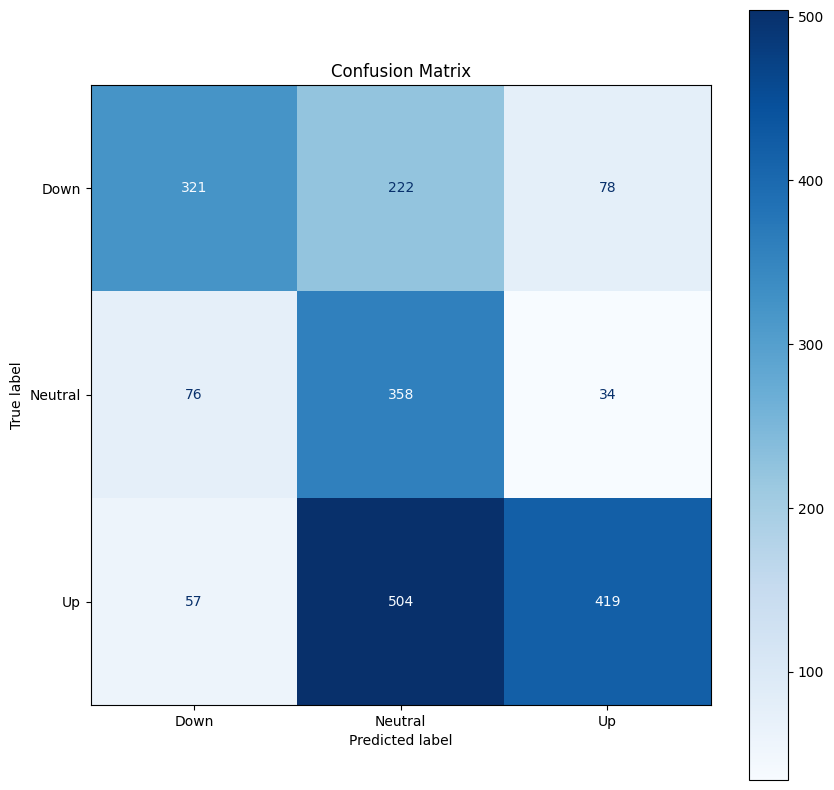

In [52]:
"""
Plot the confusion matrix for the given labels and predictions.

Args:
output_dir (str): The directory to save the confusion matrix plot.
labels (list): The true labels.
preds (list): The predicted labels.

Returns:
None
"""
conf_matrix = confusion_matrix(majority_labeled["label"], majority_labeled["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Down', 'Neutral', 'Up'])
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')

In [53]:
# Extract labels and predictions
y_true_majority = majority_labeled['label']
y_pred_majority = majority_labeled['prediction']

In [54]:
# Extract labels and predictions
y_true_mean = mean_labeled['label']
y_pred_mean = mean_labeled['prediction']

In [55]:
y_true_lstm = lstm_df["label"]
y_pred_lstm = lstm_df["prediction"]

In [56]:
import numpy as np

def calculate_tp_fp_rates(y, x):
    # Convert inputs to numpy arrays for easier manipulation
    y = np.array(y)
    x = np.array(x)
    
    # Define labels
    bullish_label = 2
    bearish_label = 0
    
    # Calculate True Positives, False Positives, False Negatives, and True Negatives for bearish against only bullish
    tp_bearish = np.sum((y == bearish_label) & (x == bearish_label))
    fp_bearish = np.sum((y == bullish_label) & (x == bearish_label))
    fn_bearish = np.sum((y == bearish_label) & (x == bullish_label))
    tn_bearish = np.sum((y == bullish_label) & (x == bullish_label))
    
    # Calculate True Positives, False Positives, False Negatives, and True Negatives for bullish against only bearish
    tp_bullish = np.sum((y == bullish_label) & (x == bullish_label))
    fp_bullish = np.sum((y == bearish_label) & (x == bullish_label))
    fn_bullish = np.sum((y == bullish_label) & (x == bearish_label))
    tn_bullish = np.sum((y == bearish_label) & (x == bearish_label))
    
    # Calculate rates
    tpr_bearish = tp_bearish / (tp_bearish + fn_bearish) if (tp_bearish + fn_bearish) > 0 else 0
    fpr_bearish = fp_bearish / (fp_bearish + tn_bearish) if (fp_bearish + tn_bearish) > 0 else 0
    tpr_bullish = tp_bullish / (tp_bullish + fn_bullish) if (tp_bullish + fn_bullish) > 0 else 0
    fpr_bullish = fp_bullish / (fp_bullish + tn_bullish) if (fp_bullish + tn_bullish) > 0 else 0
    
    return {
        'tp_bearish': tp_bearish,
        'fp_bearish': fp_bearish,
        'fn_bearish': fn_bearish,
        'tn_bearish': tn_bearish,
        'tpr_bearish': tpr_bearish,
        'fpr_bearish': fpr_bearish,
        'tp_bullish': tp_bullish,
        'fp_bullish': fp_bullish,
        'fn_bullish': fn_bullish,
        'tn_bullish': tn_bullish,
        'tpr_bullish': tpr_bullish,
        'fpr_bullish': fpr_bullish
    }

In [57]:
majority_rates = calculate_tp_fp_rates(y_true_majority, y_pred_majority)
majority_rates

{'tp_bearish': 321,
 'fp_bearish': 57,
 'fn_bearish': 78,
 'tn_bearish': 419,
 'tpr_bearish': 0.8045112781954887,
 'fpr_bearish': 0.11974789915966387,
 'tp_bullish': 419,
 'fp_bullish': 78,
 'fn_bullish': 57,
 'tn_bullish': 321,
 'tpr_bullish': 0.8802521008403361,
 'fpr_bullish': 0.19548872180451127}

In [58]:
mean_rates = calculate_tp_fp_rates(y_true_mean, y_pred_mean)
mean_rates

{'tp_bearish': 394,
 'fp_bearish': 177,
 'fn_bearish': 112,
 'tn_bearish': 571,
 'tpr_bearish': 0.7786561264822134,
 'fpr_bearish': 0.23663101604278075,
 'tp_bullish': 571,
 'fp_bullish': 112,
 'fn_bullish': 177,
 'tn_bullish': 394,
 'tpr_bullish': 0.7633689839572193,
 'fpr_bullish': 0.22134387351778656}

In [59]:
lstm_rates = calculate_tp_fp_rates(y_true_lstm, y_pred_lstm)
lstm_rates

{'tp_bearish': 135,
 'fp_bearish': 57,
 'fn_bearish': 128,
 'tn_bearish': 536,
 'tpr_bearish': 0.5133079847908745,
 'fpr_bearish': 0.09612141652613827,
 'tp_bullish': 536,
 'fp_bullish': 128,
 'fn_bullish': 57,
 'tn_bullish': 135,
 'tpr_bullish': 0.9038785834738617,
 'fpr_bullish': 0.4866920152091255}

In [64]:
def plot_tp_fp(majority_rates, mean_rates):
    # Create a scatter plot
    plt.figure(figsize=(12, 5))
    plt.scatter(majority_rates['fp_bearish'], majority_rates['tp_bearish'], color='purple', label='Majority Bearish')
    plt.scatter(majority_rates['fp_bullish'], majority_rates['tp_bullish'], color='cyan', label='Majority Bullish')
    plt.scatter(mean_rates['fp_bearish'], mean_rates['tp_bearish'], color='orange', label='Mean Bearish')
    plt.scatter(mean_rates['fp_bullish'], mean_rates['tp_bullish'], color='lime', label='Mean Bullish')

    majority_bearish_precision = majority_rates['tp_bearish'] / (majority_rates['fp_bearish'] + majority_rates['tp_bearish']) * 100
    majority_bullish_precision = majority_rates['tp_bullish'] / (majority_rates['fp_bullish'] + majority_rates['tp_bullish']) * 100
    mean_bullish_precision = mean_rates['tp_bullish'] / (mean_rates['fp_bullish'] + mean_rates['tp_bullish']) * 100
    mean_bearish_precision = mean_rates['tp_bearish'] / (mean_rates['fp_bearish'] + mean_rates['tp_bearish']) * 100

    # Annotate points
    plt.annotate(f'Majority Bearish: {round(majority_bearish_precision, 2)}% Precision', (majority_rates['fp_bearish'] + 10, majority_rates['tp_bearish'] + 10), fontsize=8, color='black')
    plt.annotate(f'Majority Bullish: {round(majority_bullish_precision, 2)}% Precision', (majority_rates['fp_bullish'] + 10, majority_rates['tp_bullish'] + 10), fontsize=8, color='black')
    plt.annotate(f'Mean Bearish: {round(mean_bearish_precision, 2)}% Precision', (mean_rates['fp_bearish'] + 10, mean_rates['tp_bearish'] + 10), fontsize=8, color='black')
    plt.annotate(f'Mean Bullish: {round(mean_bullish_precision, 2)}% Precision', (mean_rates['fp_bullish'] + 10, mean_rates['tp_bullish'] - 10), fontsize=8, color='black')

    # Add labels and title
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.xlim(0, 600)
    plt.ylim(0, 600)
    plt.savefig("./true_p_false_p.png")
    plt.show()

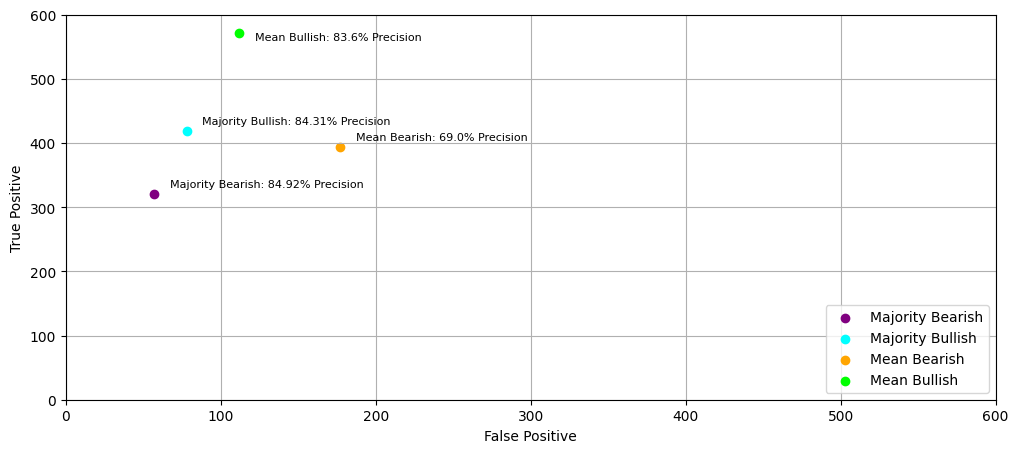

In [65]:
plot_tp_fp(majority_rates, mean_rates)

In [191]:
def plot_precision_recall(majority_rates, mean_rates, lstm_rates):
    # Calculate precision, recall, and F1 Score for each method
    def calculate_f1(precision, recall):
        return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Majority rates
    majority_bearish_precision = majority_rates['tp_bearish'] / (majority_rates['fp_bearish'] + majority_rates['tp_bearish'])
    majority_bearish_recall = majority_rates['tp_bearish'] / (majority_rates['tp_bearish'] + majority_rates['fn_bearish'])
    majority_bearish_f1 = calculate_f1(majority_bearish_precision, majority_bearish_recall)

    majority_bullish_precision = majority_rates['tp_bullish'] / (majority_rates['fp_bullish'] + majority_rates['tp_bullish'])
    majority_bullish_recall = majority_rates['tp_bullish'] / (majority_rates['tp_bullish'] + majority_rates['fn_bullish'])
    majority_bullish_f1 = calculate_f1(majority_bullish_precision, majority_bullish_recall)

    # Mean rates
    mean_bearish_precision = mean_rates['tp_bearish'] / (mean_rates['fp_bearish'] + mean_rates['tp_bearish'])
    mean_bearish_recall = mean_rates['tp_bearish'] / (mean_rates['tp_bearish'] + mean_rates['fn_bearish'])
    mean_bearish_f1 = calculate_f1(mean_bearish_precision, mean_bearish_recall)

    mean_bullish_precision = mean_rates['tp_bullish'] / (mean_rates['fp_bullish'] + mean_rates['tp_bullish'])
    mean_bullish_recall = mean_rates['tp_bullish'] / (mean_rates['tp_bullish'] + mean_rates['fn_bullish'])
    mean_bullish_f1 = calculate_f1(mean_bullish_precision, mean_bullish_recall)

    # Fusion (LSTM) rates
    fusion_bearish_precision = lstm_rates['tp_bearish'] / (lstm_rates['fp_bearish'] + lstm_rates['tp_bearish'])
    fusion_bearish_recall = lstm_rates['tp_bearish'] / (lstm_rates['tp_bearish'] + lstm_rates['fn_bearish'])
    fusion_bearish_f1 = calculate_f1(fusion_bearish_precision, fusion_bearish_recall)

    fusion_bullish_precision = lstm_rates['tp_bullish'] / (lstm_rates['fp_bullish'] + lstm_rates['tp_bullish'])
    fusion_bullish_recall = lstm_rates['tp_bullish'] / (lstm_rates['tp_bullish'] + lstm_rates['fn_bullish'])
    fusion_bullish_f1 = calculate_f1(fusion_bullish_precision, fusion_bullish_recall)

    # Create the scatter plot with different markers
    plt.figure(figsize=(5, 5))
    plt.scatter(majority_bearish_recall, majority_bearish_precision, color='purple', marker='o', label='Majority Bearish')
    plt.scatter(majority_bullish_recall, majority_bullish_precision, color='cyan', marker='s', label='Majority Bullish')
    plt.scatter(mean_bearish_recall, mean_bearish_precision, color='orange', marker='^', label='Mean Bearish')
    plt.scatter(mean_bullish_recall, mean_bullish_precision, color='lime', marker='v', label='Mean Bullish')
    plt.scatter(fusion_bearish_recall, fusion_bearish_precision, color='pink', marker='D', label='Fusion Bearish')
    plt.scatter(fusion_bullish_recall, fusion_bullish_precision, color='crimson', marker='X', label='Fusion Bullish')

    # Add arrows for annotations
    plt.annotate(f'Majority Bullish F1: {majority_bullish_f1 * 100:.1f}%', xy=(majority_bullish_recall, majority_bullish_precision),
                 xytext=(majority_bullish_recall - 0.27, majority_bullish_precision + 0.08),
                 fontsize=8, color='black', arrowprops=dict(arrowstyle='->', lw=0.5))
    plt.annotate(f'Majority Bearish F1: {majority_bearish_f1 * 100:.1f}%', xy=(majority_bearish_recall, majority_bearish_precision),
                 xytext=(majority_bearish_recall - 0.37, majority_bearish_precision + 0.03),
                 fontsize=8, color='black', arrowprops=dict(arrowstyle='->', lw=0.5))
    plt.annotate(f'Mean Bearish F1: {mean_bearish_f1 * 100:.1f}%', xy=(mean_bearish_recall, mean_bearish_precision),
                 xytext=(mean_bearish_recall - 0.39, mean_bearish_precision - 0.06),
                 fontsize=8, color='black', arrowprops=dict(arrowstyle='->', lw=0.5))
    plt.annotate(f'Mean Bullish F1: {mean_bullish_f1 * 100:.1f}%', 
                 (mean_bullish_recall - 0.36, mean_bullish_precision - 0.01), fontsize=8, color='black')
    plt.annotate(f'Fusion Bullish F1: {fusion_bullish_f1 * 100:.1f}%', xy=(fusion_bullish_recall, fusion_bullish_precision),
                 xytext=(fusion_bullish_recall - 0.35, fusion_bullish_precision - 0.06),
                 fontsize=8, color='black', arrowprops=dict(arrowstyle='->', lw=0.5))
    plt.annotate(f'Fusion Bearish F1: {fusion_bearish_f1 * 100:.1f}%', 
                 (fusion_bearish_recall - 0.39, fusion_bearish_precision - 0.01), fontsize=8, color='black')

    # Add labels and title
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")

    # Transparent grid
    plt.grid(True, alpha=0.3)  # Adjust grid transparency
    plt.xlim(0, 1)  # Recall ranges from 0 to 1
    plt.ylim(0, 1)  # Precision ranges from 0 to 1

    # Save and display
    plt.savefig("./precision_recall_scatter.png")
    plt.show()

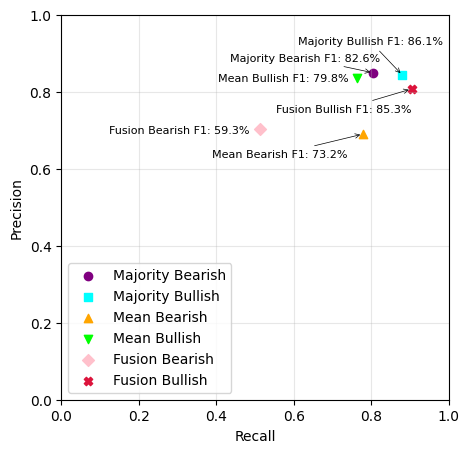

In [192]:
plot_precision_recall(majority_rates, mean_rates, lstm_rates)

In [102]:
# Create a mask for the conditions
mask = (
    ((y_true_majority == 2) & (y_pred_majority == 2)) |  # Correctly predicted bullish
    ((y_true_majority == 0) & (y_pred_majority == 0)) |  # Correctly predicted bearish
    ((y_true_majority == 2) & (y_pred_majority == 0)) |  # Predicted bearish but actually bullish
    ((y_true_majority == 0) & (y_pred_majority == 2))    # Predicted bullish but actually bearish
)

# Apply the mask to filter the series
y_true_majority_filtered = y_true_majority[mask]
y_pred_majority_filtered = y_pred_majority[mask]

In [103]:
# Create a mask for the conditions
mask = (
    ((y_true_mean == 2) & (y_pred_mean == 2)) |  # Correctly predicted bullish
    ((y_true_mean == 0) & (y_pred_mean == 0)) |  # Correctly predicted bearish
    ((y_true_mean == 2) & (y_pred_mean == 0)) |  # Predicted bearish but actually bullish
    ((y_true_mean == 0) & (y_pred_mean == 2))    # Predicted bullish but actually bearish
)

# Apply the mask to filter the series
y_true_mean_filtered = y_true_mean[mask]
y_pred_mean_filtered = y_pred_mean[mask]

In [104]:
# Create a mask for the conditions
mask = (
    ((y_true_lstm == 2) & (y_pred_lstm == 2)) |  # Correctly predicted bullish
    ((y_true_lstm == 0) & (y_pred_lstm == 0)) |  # Correctly predicted bearish
    ((y_true_lstm == 2) & (y_pred_lstm == 0)) |  # Predicted bearish but actually bullish
    ((y_true_lstm == 0) & (y_pred_lstm == 2))    # Predicted bullish but actually bearish
)

# Apply the mask to filter the series
y_true_lstm_filtered = y_true_lstm[mask]
y_pred_lstm_filtered = y_pred_lstm[mask]

In [105]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_classification_metrics(y, x, pos_label=2):
    """
    Calculate classification metrics between bullish and bearish labels.

    Args:
    y (array-like): True labels.
    x (array-like): Predicted labels.

    Returns:
    dict: Dictionary containing precision, recall, F1-score, and accuracy.
    """
    # Convert inputs to numpy arrays for easier manipulation
    y = np.array(y)
    x = np.array(x)

    # Calculate metrics
    precision = precision_score(y, x, pos_label=pos_label)
    recall = recall_score(y, x, pos_label=pos_label)
    f1 = f1_score(y, x, pos_label=pos_label)
    accuracy = accuracy_score(y, x)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    }

In [106]:
metrics = calculate_classification_metrics(y_true_majority_filtered, y_pred_majority_filtered)
metrics

{'precision': 0.8421052631578947,
 'recall': 0.7578947368421053,
 'f1': 0.7977839335180056,
 'accuracy': 0.7933962264150943}

In [56]:
metrics = calculate_classification_metrics(y_true_majority_filtered, y_pred_majority_filtered, pos_label=0)
metrics

{'precision': 0.7477148080438757,
 'recall': 0.8346938775510204,
 'f1': 0.7888138862102217,
 'accuracy': 0.7933962264150943}

In [57]:
metrics = calculate_classification_metrics(y_true_mean_filtered, y_pred_mean_filtered)
metrics

{'precision': 0.8383404864091559,
 'recall': 0.6910377358490566,
 'f1': 0.7575953458306399,
 'accuracy': 0.7401247401247402}

In [58]:
metrics = calculate_classification_metrics(y_true_mean_filtered, y_pred_mean_filtered, pos_label=0)
metrics

{'precision': 0.6478494623655914,
 'recall': 0.8100840336134454,
 'f1': 0.7199402539208365,
 'accuracy': 0.7401247401247402}

In [107]:
metrics = calculate_classification_metrics(y_true_lstm_filtered, y_pred_lstm_filtered)
metrics

{'precision': 0.8072289156626506,
 'recall': 0.9038785834738617,
 'f1': 0.8528241845664281,
 'accuracy': 0.7838785046728972}

In [108]:
metrics = calculate_classification_metrics(y_true_lstm_filtered, y_pred_lstm_filtered, pos_label=0)
metrics

{'precision': 0.703125,
 'recall': 0.5133079847908745,
 'f1': 0.5934065934065934,
 'accuracy': 0.7838785046728972}

In [59]:
confusion_matrix(y_true_majority_filtered, y_pred_majority_filtered)

array([[409,  81],
       [138, 432]])

In [60]:
confusion_matrix(y_true_mean_filtered, y_pred_mean_filtered)

array([[482, 113],
       [262, 586]])

In [109]:
confusion_matrix(y_true_lstm_filtered, y_pred_lstm_filtered)

array([[135, 128],
       [ 57, 536]])

In [61]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix components for majority predictions
tn_majority, fp_majority, fn_majority, tp_majority = confusion_matrix(y_true_majority_filtered, y_pred_majority_filtered, labels=[0, 2]).ravel()

# Calculate TPR and FPR for majority predictions
tpr_majority_bullish = tp_majority / (tp_majority + fn_majority)
fpr_majority_bullish = fp_majority / (fp_majority + tn_majority)

# Calculate confusion matrix components for mean predictions
tn_mean, fp_mean, fn_mean, tp_mean = confusion_matrix(y_true_mean_filtered, y_pred_mean_filtered, labels=[0, 2]).ravel()

# Calculate TPR and FPR for mean predictions
tpr_mean_bullish = tp_mean / (tp_mean + fn_mean)
fpr_mean_bullish = fp_mean / (fp_mean + tn_mean)

# Print the results
print(f"Majority Bullish TPR: {tpr_majority_bullish:.2f}")
print(f"Majority Bullish FPR: {fpr_majority_bullish:.2f}")
print(f"Mean Bullish TPR: {tpr_mean_bullish:.2f}")
print(f"Mean Bullish FPR: {fpr_mean_bullish:.2f}")

Majority Bullish TPR: 0.76
Majority Bullish FPR: 0.17
Mean Bullish TPR: 0.69
Mean Bullish FPR: 0.19


In [67]:
def plot_tpr_fpr(majority_rates, mean_rates):
    # Calculate TPR and FPR for majority rates
    majority_rates['tpr_bearish'] = majority_rates['tp_bearish'] / (majority_rates['tp_bearish'] + majority_rates['fn_bearish'])
    majority_rates['fpr_bearish'] = majority_rates['fp_bearish'] / (majority_rates['fp_bearish'] + majority_rates['tn_bearish'])
    majority_rates['tpr_bullish'] = majority_rates['tp_bullish'] / (majority_rates['tp_bullish'] + majority_rates['fn_bullish'])
    majority_rates['fpr_bullish'] = majority_rates['fp_bullish'] / (majority_rates['fp_bullish'] + majority_rates['tn_bullish'])

    # Calculate TPR and FPR for mean rates
    mean_rates['tpr_bearish'] = mean_rates['tp_bearish'] / (mean_rates['tp_bearish'] + mean_rates['fn_bearish'])
    mean_rates['fpr_bearish'] = mean_rates['fp_bearish'] / (mean_rates['fp_bearish'] + mean_rates['tn_bearish'])
    mean_rates['tpr_bullish'] = mean_rates['tp_bullish'] / (mean_rates['tp_bullish'] + mean_rates['fn_bullish'])
    mean_rates['fpr_bullish'] = mean_rates['fp_bullish'] / (mean_rates['fp_bullish'] + mean_rates['tn_bullish'])

    # Create a scatter plot
    plt.figure(figsize=(12, 5))
    plt.scatter(majority_rates['fpr_bearish'], majority_rates['tpr_bearish'], color='purple', label='Majority Bearish')
    plt.scatter(majority_rates['fpr_bullish'], majority_rates['tpr_bullish'], color='cyan', label='Majority Bullish')
    plt.scatter(mean_rates['fpr_bearish'], mean_rates['tpr_bearish'], color='orange', label='Mean Bearish')
    plt.scatter(mean_rates['fpr_bullish'], mean_rates['tpr_bullish'], color='lime', label='Mean Bullish')

    # Annotate points
    plt.annotate(f'Majority Bearish: {round(majority_rates["tpr_bearish"] * 100, 2)}% TPR', (majority_rates['fpr_bearish'] + 0.01, majority_rates['tpr_bearish'] + 0.02), fontsize=8, color='black')
    plt.annotate(f'Majority Bullish: {round(majority_rates["tpr_bullish"] * 100, 2)}% TPR', (majority_rates['fpr_bullish'] + 0.01, majority_rates['tpr_bullish'] - 0.01), fontsize=8, color='black')
    plt.annotate(f'Mean Bearish: {round(mean_rates["tpr_bearish"] * 100, 2)}% TPR', (mean_rates['fpr_bearish'] + 0.01, mean_rates['tpr_bearish'] - 0.01), fontsize=8, color='black')
    plt.annotate(f'Mean Bullish: {round(mean_rates["tpr_bullish"] * 100, 2)}% TPR', (mean_rates['fpr_bullish'] + 0.01, mean_rates['tpr_bullish'] - 0.03), fontsize=8, color='black')

    # Add labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.savefig("./tpr_fpr.png")
    plt.show()

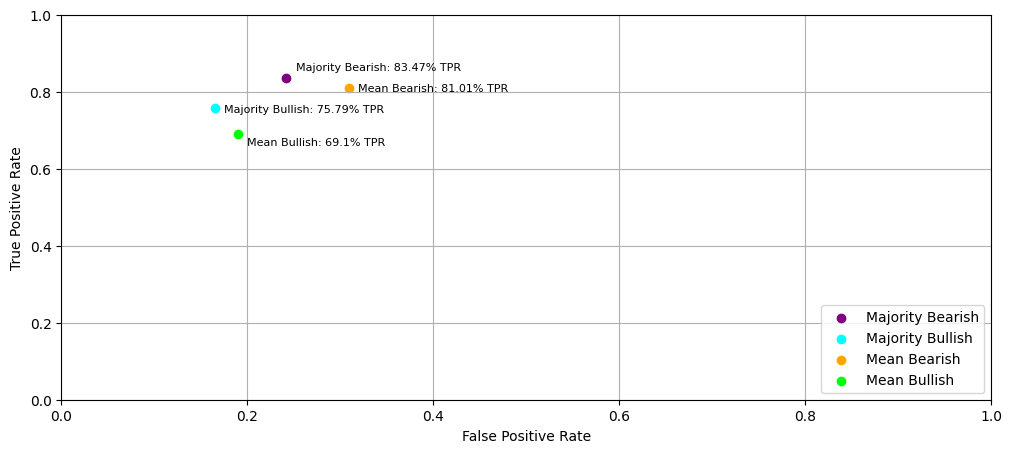

In [68]:
from sklearn.metrics import confusion_matrix

# Assuming y_true_majority_filtered and y_pred_majority_filtered are already defined
# Calculate confusion matrix components for majority predictions
tn_majority, fp_majority, fn_majority, tp_majority = confusion_matrix(y_true_majority_filtered, y_pred_majority_filtered, labels=[0, 2]).ravel()

# Construct majority_rates dictionary
majority_rates = {
    'tp_bearish': tn_majority,  # True negatives for bearish
    'fp_bearish': fn_majority,  # False negatives for bearish
    'tn_bearish': tp_majority,  # True positives for bearish
    'fn_bearish': fp_majority,  # False positives for bearish
    'tp_bullish': tp_majority,  # True positives for bullish
    'fp_bullish': fp_majority,  # False positives for bullish
    'tn_bullish': tn_majority,  # True negatives for bullish
    'fn_bullish': fn_majority   # False negatives for bullish
}

# Assuming y_true_mean_filtered and y_pred_mean_filtered are already defined
# Calculate confusion matrix components for mean predictions
tn_mean, fp_mean, fn_mean, tp_mean = confusion_matrix(y_true_mean_filtered, y_pred_mean_filtered, labels=[0, 2]).ravel()

# Construct mean_rates dictionary
mean_rates = {
    'tp_bearish': tn_mean,  # True negatives for bearish
    'fp_bearish': fn_mean,  # False negatives for bearish
    'tn_bearish': tp_mean,  # True positives for bearish
    'fn_bearish': fp_mean,  # False positives for bearish
    'tp_bullish': tp_mean,  # True positives for bullish
    'fp_bullish': fp_mean,  # False positives for bullish
    'tn_bullish': tn_mean,  # True negatives for bullish
    'fn_bullish': fn_mean   # False negatives for bullish
}

# Now you can use the plot_tpr_fpr function
plot_tpr_fpr(majority_rates, mean_rates)

In [66]:
plot_tpr_fpr(tpr_majority_bullish, tpr_mean_bullish)

IndexError: invalid index to scalar variable.